In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np

from moviepy.editor import VideoFileClip
from IPython.display import HTML

# There is code and comments used below taken from the lessons and exercises

# plotting function to display images taken from lesson

def plt_images(img_1, title_1, img_2, title_2, cmap='gray'):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_title(title_1, fontsize=16)
    ax1.imshow(img_1)
    ax2.set_title(title_2, fontsize=16)
    ax2.imshow(img_2, cmap='gray')

In [2]:
def calibrate_camera(images, nx=9, ny=6):
    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    img = None
    for file in images:
        img = cv2.imread(file)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    # Camera calibration, given object points, image points, and the shape of the grayscale image
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    return ret, mtx, dist, rvecs, tvecs

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
ret, mtx, dist, rvecs, tvecs = calibrate_camera(images)

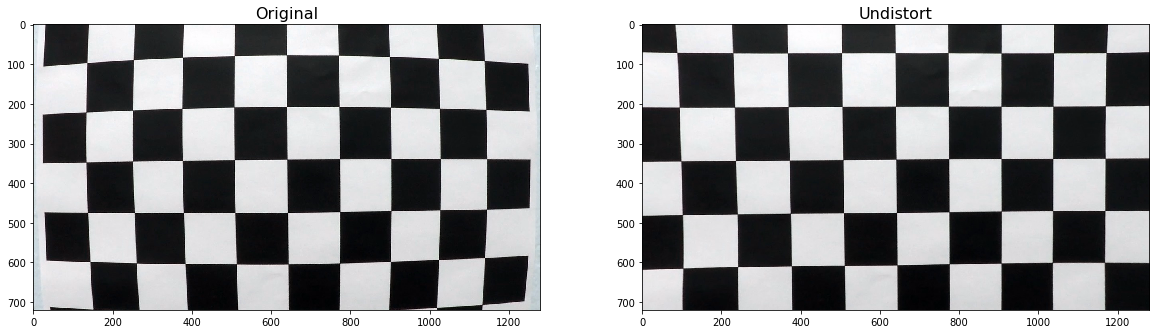

In [3]:
# Undistort a test image
img = cv2.imread('./camera_cal/calibration1.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)
plt_images(img, 'Original', undist, 'Undistort')

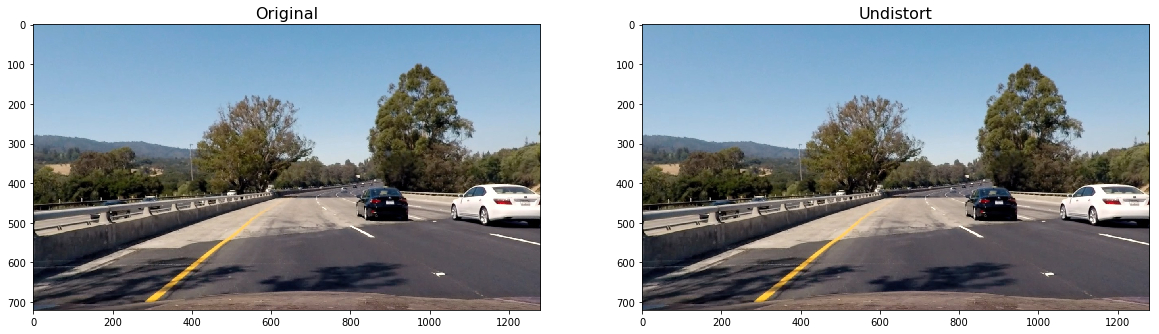

In [21]:
# Load a test image, convert to RGB and undistort it
img = cv2.imread('./test_images/test4.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.undistort(img, mtx, dist, None, mtx)

In [5]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel))
    elif orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel))
        
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary_output


In [6]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

mag_binary = mag_thresh(img, sobel_kernel=15, thresh=(70, 100))

In [7]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.

def dir_threshold(img, sobel_kernel=7, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

dir_binary = dir_threshold(img, sobel_kernel=17, thresh=(0.7, 1.3))

In [8]:
def hls_select(img, thresh=(170, 255)):
    # HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    # S Channel has proven to be very robust
    s_channel = hls[:,:,2]

    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1

    # Return the binary image
    return binary_output

col_binary = hls_select(img, thresh=(170, 255))

In [9]:
# Run the functions
gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=13, thresh=(30, 100))
grady = abs_sobel_thresh(img, orient='y', sobel_kernel=13, thresh=(30, 100))

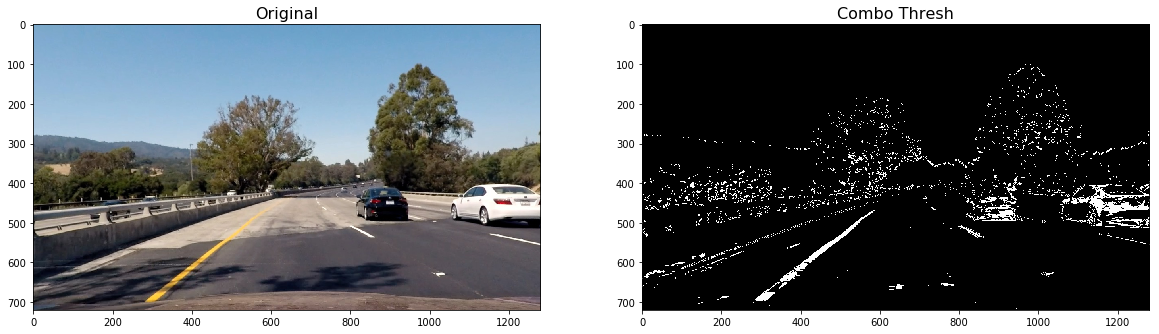

In [10]:
# combine the thresholds
def combineThresh(gradx, grady, mag_binary, dir_binary, col_binary, ksize=13):
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (col_binary == 1)] = 1
    return combined
combined = combineThresh(gradx, grady, mag_binary, dir_binary, col_binary, ksize=13)
cv2.imwrite('combinedthresh.png', combined)
plt_images(img, 'Original', combined, 'Combo Thresh')

In [11]:
# source of region
# destination of warp

src = np.float32([[280,  700], [595,  460], [725,  460], [1125, 700]])
dst = np.float32([[250,  720],[250,0],[1065,0],[1065, 720]])

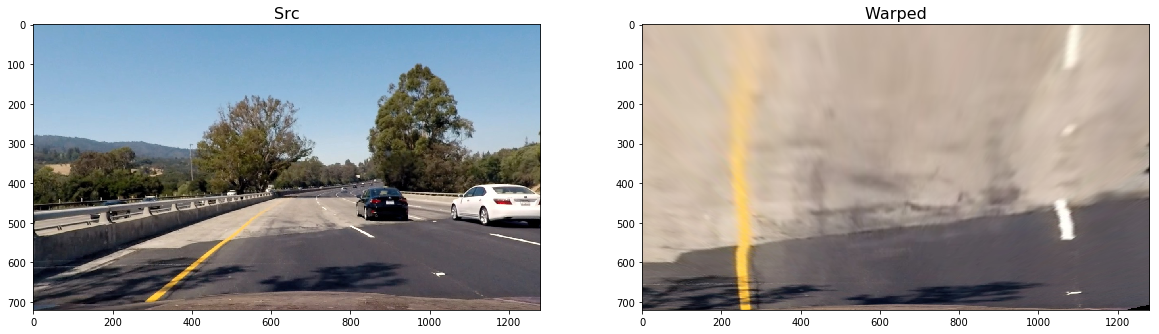

In [12]:
def corners_unwarp(img):
    img_size = (img.shape[1], img.shape[0])

    # Given src and dst points, calculate the perspective transform matrix

    M = cv2.getPerspectiveTransform(src, dst)

    # Compute the inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Warp the image using OpenCV warpPerspective()

    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M, Minv
warped_img, _ , Minv  = corners_unwarp(img)
combo_warp = corners_unwarp(combined)[0]
plt_images(img, 'Src', warped_img, 'Warped')

In [13]:
def detect_lines(img):
    # create histogram data off of the bottom half because lane lines are most likely to be vertical
    histogram = np.sum(img[img.shape[0]//2:, :], axis=0)

    # find the base of the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Number of windows
    nwindows = 9

    # Set height of windows
    window_height = np.int(img.shape[0]//nwindows)

    # Identify the x and y positions of all nonzero i.e. activated pixels in the image
    nonzero = img.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])


    # Current positions to be updated later for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window + 1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty)

lines, left_points, right_points = detect_lines(combo_warp)

In [14]:
def search_around_poly(img, line_e=None):
    margin = 100
    
    if line_e is None:
        return detect_lines(img)

    left_fit = line_e[0]
    right_fit = line_e[1]

    # grab acitvated pixels
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    
    # Set the area of search on x values
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy +
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) +
    left_fit[1]*nonzeroy + left_fit[2] + margin)))

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy +
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) +
    right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ## Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty)

lines, left_points, right_points = search_around_poly(combo_warp, lines)


In [15]:
def measure_curvature_real (leftx, rightx, img_shape, xm_per_pix=3.7/800, ym_per_pix = 25/720):
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    # generate some fake data
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 25/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/800 # meters per pixel in x dimension

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

     # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad)
curvRes = measure_curvature_real(leftx=left_points[0], rightx=right_points[0], img_shape = img.shape)


In [16]:
def carPos(leftx, rightx, img_shape, xm_per_pix=3.7/800):
    # middle of image
    mid_imgx = img_shape[1]//2

    # left/right checker
    balance = (leftx[-1] + rightx[-1])/2

    # horizontal distance
    horiz = (mid_imgx - balance) * xm_per_pix

    return horiz
horiz = carPos(leftx=left_points[0], rightx=right_points[0], img_shape=img.shape)


In [17]:
def draw_lane(img, warped_img, left_points, right_points, Minv, leftx, rightx, xm_per_pix=3.7/800, ym_per_pix = 25/720):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = left_points[0]
    right_fitx = right_points[0]
    ploty = left_points[1]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))

    # Combine the result with the original image
    img = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    # returns curve calculations 
    curvRes = measure_curvature_real(leftx=leftx, rightx=rightx, img_shape=img.shape,
                                      xm_per_pix=xm_per_pix, ym_per_pix=ym_per_pix)
    # Calculate offset
    horiz = carPos(leftx=leftx, rightx=rightx, img_shape=img.shape)
    
    # Display info
    out_img = img.copy()
    cv2.putText(out_img, 'Left lane curve: {:.2f} m'.format(curvRes[0]),
                (50, 60), font, 1.5, (255,255,255), 2)
    cv2.putText(out_img, 'Right lane curve: {:.2f} m'.format(curvRes[1]),
                (50, 100), font, 1.5, (255,255,255), 2)

    # Display car offset
    cv2.putText(out_img, 'Horizontal car offset: {:.2f} m'.format(horiz),
                (50, 150), font, 1.5, (255,255,255), 2)
    
    return out_img


In [18]:
class image_process:
    def __init__(self, images):
        # Recalibrate
        images = glob.glob(images)
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = calibrate_camera(images)
        self.lines = None

    def __call__(self, img):
        # Main pipeline running through all the functions we already made
        img = cv2.undistort(img, mtx, dist, None, mtx)
        sob_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=15, thresh=(40, 90))
        mag_binary = mag_thresh(img, sobel_kernel=15, thresh=(40, 90))
        dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
        col_binary = hls_select(img, thresh=(160, 245))
        combined = combineThresh(gradx, grady, mag_binary, dir_binary, col_binary, ksize=15)
        combo_warp, _, Minv = corners_unwarp(combined)
        self.lines, left_points, right_points = search_around_poly(combo_warp, self.lines)
        result = draw_lane(img, combo_warp, left_points, right_points, Minv,leftx=left_points[0], rightx=right_points[0])
        return result

In [19]:
input_video = './project_video.mp4'
output_video = './output.mp4'

clip1 = VideoFileClip(input_video)

process_image = image_process('./camera_cal/calibration*.jpg')

white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video ./output.mp4
[MoviePy] Writing video ./output.mp4


100%|█████████▉| 1260/1261 [03:44<00:00,  6.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output.mp4 

CPU times: user 6min 45s, sys: 31.2 s, total: 7min 16s
Wall time: 3min 45s


In [20]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output_video))